# Binary Classification of Text using an LSTM Neural Network
- Develop a recurrent neural network that is capable of accurately classifying a news article as real or fake news.

## Data Sources
- True.csv: dataset of real/true news articles downloaded from Kaggle (https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset/download)
- Fake.csv: dataset of fake/false news articles downloaded from Kaggle (https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset/download)

## Imports

In [1]:
# Basic Packages and Set Seed
import time
import pandas as pd
import numpy as np 
np.random.seed(830)
SEED = 830

# Data Preparation
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Model building
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Visualizations
import matplotlib
import matplotlib.pyplot as plt

In [2]:
start = time.time()

### Package versions for reproducibility 

In [3]:
print('Package Versions:\n')
print('TensorFlow:',tf.__version__)
print('Keras:',keras.__version__)
print('Numpy:',np.__version__)
print('Pandas:',pd.__version__)
print('NLTK:',nltk.__version__)
print('Scikit-Learn:',sklearn.__version__)
print('Matplotlib:',matplotlib.__version__)

Package Versions:

TensorFlow: 2.3.0
Keras: 2.4.0
Numpy: 1.19.1
Pandas: 1.2.4
NLTK: 3.6.1
Scikit-Learn: 0.24.1
Matplotlib: 3.3.4


## Data Preparation
### Load Data

In [2]:
# Load Data with only title column
df_real = pd.read_csv('True.csv', encoding='UTF-8').drop(['title', 'subject', 'date'], axis=1)
df_fake = pd.read_csv('Fake.csv', encoding='UTF-8').drop(['title', 'subject', 'date'], axis=1)

# Add label column to each to identify title real (0) or fake (1) article
df_real['label'] = 0
df_fake['label'] = 1

# Concatenate DataFrames
df = pd.concat([df_real, df_fake])

# Shuffle the dataframe
df = df.sample(frac=1).reset_index().drop('index', axis=1)

# Inspect dataframe
df.head()

,text,label
0,"Earlier today, it was reported by TMZ that an ...",1
1,(Reuters) - Goldman Sachs Group Inc (GS.N) Chi...,0
2,"A journalist and author, Daniel Hannan has bee...",1
3,UNITED NATIONS (Reuters) - The next round of t...,0
4,WASHINGTON (Reuters) - The White House said in...,0


### Prepare the Data

In [5]:
# Assign stopwords to a list
stop_words = stopwords.words('English')
# Assign a lemmatizer
lemmatizer = WordNetLemmatizer().lemmatize

In [6]:
# Create a list to store cleaned text
texts = list()

# Loop through articles to clean the text
for i in range(0,len(df)):
    sentence = df.text[i]
    # Tokenize in lowercase
    lower_tokens = [t for t in word_tokenize(sentence.lower())]
    # Remove Stopwords and lemmatize
    lemmed = [lemmatizer(l) for l in lower_tokens if not l in stop_words]
    # Retain only alphabetic words, remove punctuation tokens
    alpha_lemmed = [lm for lm in lemmed if lm.isalpha()]
    # Join back into one token
    text_lem = ' '.join(alpha_lemmed)
    # Append to list
    texts.append(text_lem)

# Create new dataframe from cleaned article texts
df_text = pd.DataFrame({'text':texts, 'label':df.label})

# Save cleaned data
df_text.to_csv('cleaned_texts.csv', index=False)

### Explore Vocab size and article length

In [7]:
# Create lists to store words and sentences
vocab = list()
sentences = list()

# Loop through titles to create vocab
for sentence in df_text.text.values:
    # Tokenize in lowercase
    tokens = [t for t in word_tokenize(sentence.lower())]
    # append to list of sentences
    sentences.append(tokens)
    # add words from sentence to vocab list
    for a in tokens:
        vocab.append(a)
        
# create set of unique values from vocab
vocab = list(set(vocab))

print('Vocab Size: %s'%len(vocab))

Vocab Size: 92340


In [8]:
# Create list to store number of words in each sentence
sent_length = list()

# Loop through sentences and append length in words to sent_length
for s in sentences:
    sent_length.append(len(s))
    
# Convert to dataframe
sent_length = pd.DataFrame(sent_length)

<AxesSubplot:>

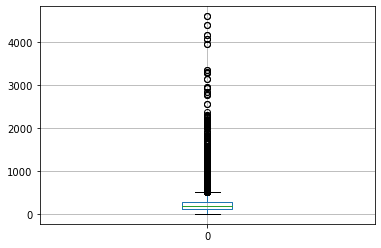

In [9]:
sent_length.boxplot()

In [10]:
sent_length.describe()

,0
count,44898.000000
mean,219.820660
std,191.016342
min,0.000000
25%,111.000000
50%,193.000000
75%,275.000000
max,4606.000000


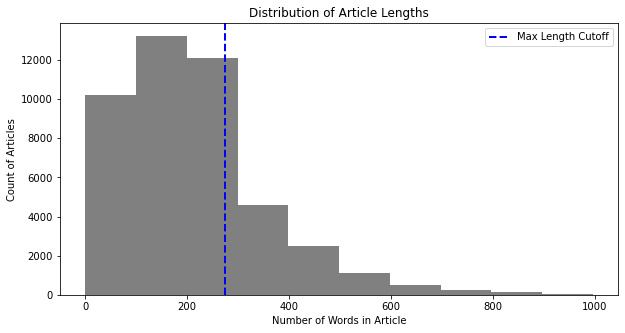

In [11]:
# plot histogram of sentence lengths
plt.figure(figsize=(10, 5))
plt.hist(sent_length[sent_length<1000], color='grey')
plt.axvline(x=275, color='b', linestyle='dashed', 
            linewidth=2, label='Max Length Cutoff')
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Words in Article')
plt.ylabel('Count of Articles')
plt.legend()
plt.show()

## Initial Model Building

In [12]:
# Separate data into predictor and response
X = df_text.text
y = df_text.label

# Create train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Instantiate a Tokenizer
vocab_size = 10000
max_len = 275
tokenizer = Tokenizer(num_words=vocab_size)

# Fit tokenizer on training data
tokenizer.fit_on_texts(X_train.values)

# Create padded sequence of train and test data using tokenizer
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

In [13]:
# Instantiate the Neural Network Model
model = Sequential()

# Add layers to model
model.add(Embedding(input_dim=vocab_size, output_dim=64, trainable=True, 
                    input_length=max_len, name='Embedding')) 
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, name='LSTM'))
model.add(Dense(8, activation='relu', name='Dense'))
model.add(Dense(1, activation='sigmoid', name='Output'))

# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# Display the model Architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 275, 64)           640000    
_________________________________________________________________
LSTM (LSTM)                  (None, 32)                12416     
_________________________________________________________________
Dense (Dense)                (None, 8)                 264       
_________________________________________________________________
Output (Dense)               (None, 1)                 9         
Total params: 652,689
Trainable params: 652,689
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

# Fit the model on the training data, using 15% of it as validation. 
history = model.fit(X_train_padded, y_train, validation_split=0.3, 
                    epochs=20, batch_size=500,
                    callbacks=[early_stopping_monitor])
# Save the model for future use
model.save('LSTM_model')

Epoch 1/20
51/51 [==============================] - 73s 1s/step - loss: 0.5156 - accuracy: 0.8539 - val_loss: 0.2872 - val_accuracy: 0.9008
Epoch 2/20
51/51 [==============================] - 88s 2s/step - loss: 0.1736 - accuracy: 0.9476 - val_loss: 0.1319 - val_accuracy: 0.9591
Epoch 3/20
51/51 [==============================] - 94s 2s/step - loss: 0.0816 - accuracy: 0.9757 - val_loss: 0.0908 - val_accuracy: 0.9720
Epoch 4/20
51/51 [==============================] - 96s 2s/step - loss: 0.0469 - accuracy: 0.9877 - val_loss: 0.0756 - val_accuracy: 0.9770
Epoch 5/20
51/51 [==============================] - 98s 2s/step - loss: 0.0336 - accuracy: 0.9916 - val_loss: 0.0704 - val_accuracy: 0.9797
Epoch 6/20
51/51 [==============================] - 101s 2s/step - loss: 0.0222 - accuracy: 0.9949 - val_loss: 0.0608 - val_accuracy: 0.9835
Epoch 7/20
51/51 [==============================] - 99s 2s/step - loss: 0.0254 - accuracy: 0.9935 - val_loss: 0.0668 - val_accuracy: 0.9801
Epoch 8/20
51/51 [=

### Assess overfitting of model

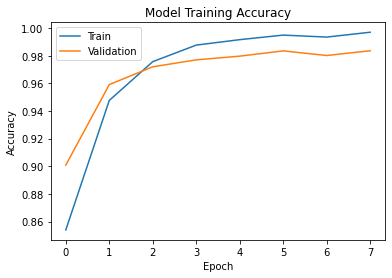

In [16]:
# Plot accuracy for training and Validation during model fitting
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

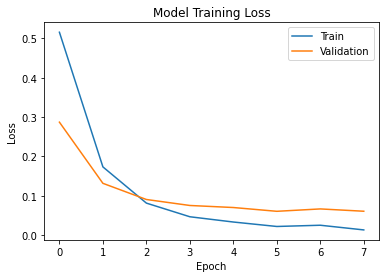

In [17]:
# Plot Loss for training and Validation during model fitting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

## Model Evaluation

In [18]:
# Load the saved model from above
model = keras.models.load_model('LSTM_model')

In [19]:
# Evaluate on test data
accuracy = (model.evaluate(X_test_padded, y_test)[1])*100
print('\nModel Accuracy on Test Data: {}%'.format(round(accuracy, 1)))

281/281 [==============================] - 7s 23ms/step - loss: 0.0577 - accuracy: 0.9841

Model Accuracy on Test Data: 98.4%


In [36]:
# Calculate predictions and assign 1 or 0
pred = list()
for value in model.predict(X_test_padded):
    if value > 0.5: pred.append(1)
    else: pred.append(0)

# Show classification report for test data
print(sklearn.metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4282
           1       0.98      0.99      0.98      4698

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



In [20]:
end = time.time()
runtime = end - start
print('Notebook Runtime (minutes): {}'.format(runtime/60))

Notebook Runtime (minutes): 16.947394784291586
